# Generative Adversarial Networks


[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661), are a type of computer program that can create new images or data. They consist of two main parts: a Generator and a Discriminator.

The Generator's job is to create new images or data that look real. It starts by making random images or data, and then it gets feedback from the Discriminator. The Discriminator's job is to decide whether an image or data is real or fake. It looks at both real examples from a training set and the images or data created by the Generator. Based on this, it tries to guess whether each image or data is real or fake.

The Generator and Discriminator are trained together, but they have opposite goals. The Generator wants to create images or data that the Discriminator will think are real, while the Discriminator wants to correctly identify which images or data are real and which are fake.

During training, the Generator keeps improving its ability to create realistic images or data. It tries to fool the Discriminator by making its creations look as real as possible. The Discriminator, on the other hand, keeps getting better at distinguishing between real and fake examples.

As training progresses, the Generator becomes so good at creating realistic images or data that the Discriminator can no longer tell the difference between real and fake. This means that the Generator has successfully learned to generate high-quality images or data that are similar to the ones it was trained on.

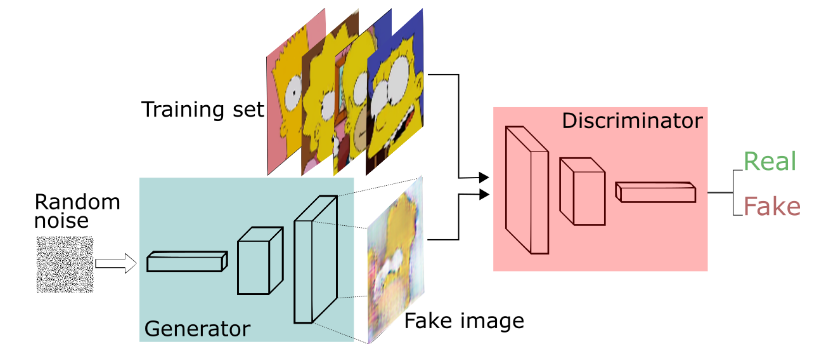

In [1]:
from glob import glob
from PIL import Image
from IPython import display
import tensorflow.keras as kr
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os

In [2]:
BATCH_SIZE = 128
LATENT_DIM = 100
SAMPLE_INTERVAL = 200
EPOCHS = 10000

**Utility Functions**

In [3]:
def generate_gif(gif_name='mnist_gan.gif', pattern='image*.png'):
    with imageio.get_writer(gif_name, mode='I') as writer:
        filenames = glob(pattern)
        filenames = sorted(filenames)
        last = -1
        for i,filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
            
        image = imageio.imread(filename)
        writer.append_data(image)

    # this is a hack to display the gif inside the notebook
    os.system('cp {} {}.png'.format(gif_name, gif_name))

In [4]:
def sample_images(generator, epoch, save=True, name='mnist'):
    """ Sample images from generator, plot them and save as png"""

    noise = np.random.normal(size=(5 * 5, LATENT_DIM))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5     # Rescale images 0-1

    fig, axs = plt.subplots(5, 5)
    c = 0
    for i in range(5):
        for j in range(5):
            axs[i,j].imshow(gen_imgs[c, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            c += 1
            
    if save:
        fig.savefig("{}_{}.png".format(name, epoch))
        plt.close()
    else:
        plt.show()

### Starting with MNIST

We are going start with MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [5]:
(X, _), (_, _) = kr.datasets.mnist.load_data()

X = X.reshape(X.shape[0], 28, 28, 1).astype('float32')
X = (X - 127.5) / 127.5 # Normalize the images to [-1, 1]

11493376/11490434 [==============================] - 0s 0us/step


### The Generator Model

The generator will try to create images that are good enough to fool the discriminator. First, we are going to start with a simple model - with Dense layers -.

In [6]:
def build_generator(output_shape=(28, 28, 1)): 
    model = kr.Sequential(name='generator')
    
    model.add(kr.layers.Dense(256, input_shape=(LATENT_DIM, )))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(512))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(1024))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(np.prod(output_shape), activation='tanh'))
    model.add(kr.layers.Reshape(output_shape))

    return model


generator = build_generator()
generator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 512)               2048      
_________________________________________________________________
dens

### The Discriminator model

The discriminator will try to distinguish fake images from real images. 

In [7]:
def build_discriminator(input_shape=(28, 28, 1)):
    model = kr.Sequential(name='discriminator')

    model.add(kr.layers.Flatten(input_shape=input_shape))
    model.add(kr.layers.Dense(512))
    model.add(kr.layers.LeakyReLU(alpha=0.2))

    model.add(kr.layers.Dense(256))
    model.add(kr.layers.LeakyReLU(alpha=0.2))

    model.add(kr.layers.Dense(1, activation='sigmoid'))

    return model


discriminator = build_discriminator()
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [8]:
optimizer = kr.optimizers.Adam(0.0002, 0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['acc'])
discriminator.trainable = False    # For GAN we will only train the generator

z = kr.Input(shape=(LATENT_DIM,)) 
valid = discriminator(generator(z))

model = kr.Model(z, valid)
model.compile(loss='binary_crossentropy', optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
generator (Sequential)       (None, 28, 28, 1)         1493520   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [9]:
# Adversarial ground truths
valid_labels = np.ones((BATCH_SIZE, 1))
fake_labels = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
    
    # Shuffle and batch data 
    imgs = X[np.random.randint(0, X.shape[0], BATCH_SIZE)] 
    
    loss_real = discriminator.train_on_batch(imgs, valid_labels)
    loss_fake = discriminator.train_on_batch(generator.predict(noise), fake_labels)
    d_loss, d_acc = 0.5 * np.add(loss_real, loss_fake)
    
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
    g_loss = model.train_on_batch(noise, valid_labels)
    display.clear_output(wait=True)
    print ("Epoch : %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss, 100*d_acc, g_loss))

    # If at save interval => save generated image samples
    if epoch % SAMPLE_INTERVAL == 0:
        sample_images(generator, epoch, name='../working/mnist')

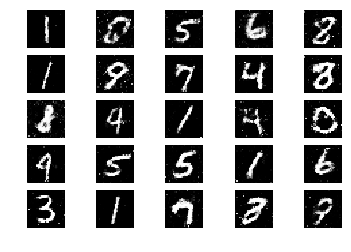

In [10]:
sample_images(generator, None, save=False)

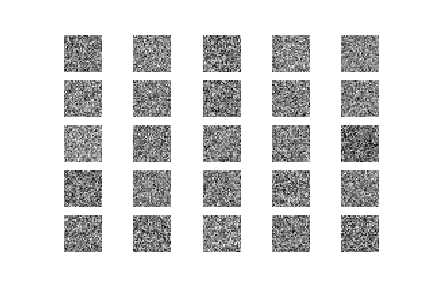

In [11]:
generate_gif(gif_name='../working/mnist_gan.gif', pattern='../working/mnist*.png')
display.Image(filename="../working/mnist_gan.gif.png")

It doesn't look bad for a starter model, does it?.

## DC-GAN with Fashion MNIST

Now, let's change our data to Fashion MNIST to generate clothes meanwhile using the Deep Convolutional GAN model.

In [12]:
(X, _), (_, _) = kr.datasets.fashion_mnist.load_data()

X = X.reshape(X.shape[0], 28, 28, 1).astype('float32')
X = (X - 127.5) / 127.5 # Normalize the images to [-1, 1]

4423680/4422102 [==============================] - 0s 0us/step


### The Generator Model

In [13]:
def generator_model():
    model = kr.Sequential()
    
    model.add(kr.layers.Dense(7 * 7 * 128, activation="relu", input_shape=(LATENT_DIM,)))
    model.add(kr.layers.Reshape((7, 7, 128)))
    
    model.add(kr.layers.UpSampling2D())
    model.add(kr.layers.Conv2D(128, (3, 3), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.ReLU())

    model.add(kr.layers.UpSampling2D())
    model.add(kr.layers.Conv2D(64, (3, 3), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.ReLU())

    model.add(kr.layers.Conv2D(1, (3, 3), padding='same', activation='tanh'))
  
    return model


generator = generator_model()
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)       0         
__________

### The Discriminator model

It's similar to a regular CNN-based image classifier.

In [14]:
def discriminator_model():
    model = kr.Sequential()
    
    model.add(kr.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))
      
    model.add(kr.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    # model.add(kr.layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))
    
    model.add(kr.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))
    
    model.add(kr.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))
       
    model.add(kr.layers.Flatten())
    model.add(kr.layers.Dense(1, activation='sigmoid'))
     
    return model


discriminator = discriminator_model()
discriminator.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 64)          0         
___________________________

**Compile our DC-GAN Model**

In [15]:
optimizer = kr.optimizers.Adam(0.0002, 0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['acc'])
discriminator.trainable = False    # For GAN we will only train the generator

z = kr.Input(shape=(LATENT_DIM,)) 
valid = discriminator(generator(z))

model = kr.Model(z, valid)
model.compile(loss='binary_crossentropy', optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         856193    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 390657    
Total params: 1,246,850
Trainable params: 855,809
Non-trainable params: 391,041
_________________________________________________________________


In [16]:
# Adversarial ground truths
valid_labels = np.ones((BATCH_SIZE, 1))
fake_labels = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
    
    # Shuffle and batch data 
    imgs = X[np.random.randint(0, X.shape[0], BATCH_SIZE)] 
    
    loss_real = discriminator.train_on_batch(imgs, valid_labels)
    loss_fake = discriminator.train_on_batch(generator.predict(noise), fake_labels)
    d_loss, d_acc = 0.5 * np.add(loss_real, loss_fake)
    
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
    g_loss = model.train_on_batch(noise, valid_labels)
    display.clear_output(wait=True)
    print ("Epoch : %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss, 100*d_acc, g_loss))

    # If at save interval => save generated image samples
    if epoch % SAMPLE_INTERVAL == 0:
        sample_images(generator, epoch, name='../working/fmnist')

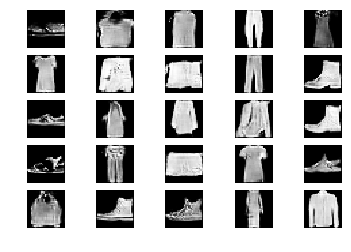

In [17]:
sample_images(generator, None, save=False, name='../working/fmnist')

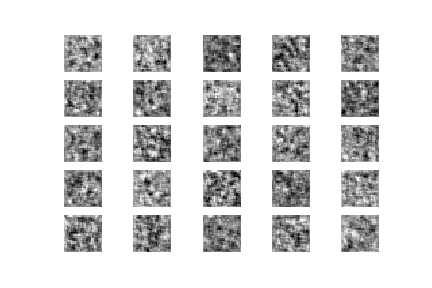

In [18]:
generate_gif(gif_name='../working/fmnist_gan.gif', pattern='../working/fmnist*.png')
display.Image(filename="../working/fmnist_gan.gif.png")

## End

I would like to mention that training GAN is really hard as they are so sensetive to hyperparameters. Sometimes it is possible that the generation loss will became 0 and discriminator loss will keep increasing. Before starting to train a model of your own, it may save your time to find a proven to be working models. Lastly, don't forget to upvote if you like my kernel!